In [ ]:
import numpy as np
from PIL import Image
import taichi as ti
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from utils import run_optimization, resample_polyline, get_area

ti.init(arch=ti.gpu)

[Taichi] Starting on arch=cuda


(np.float64(-1.975),
 np.float64(2.975),
 np.float64(-0.9699999999999999),
 np.float64(0.57))

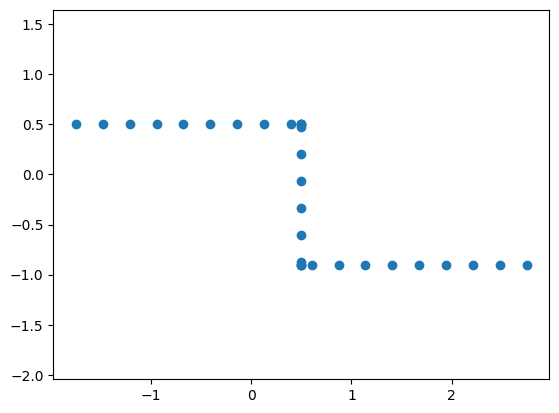

In [34]:
def init_trajectory(sofa_w, sofa_h, control_point_num, middle_rotation=-0.5 * np.pi, offset=1):  # 生成初始轨迹
    xs, ys, rotations = resample_polyline([
        [-sofa_w / 2, 0.5, 0],
        [0.5, 0.5, 0],
        [0.5, 0.5, middle_rotation],
        [0.5, 0.5 - offset, middle_rotation],
        [0.5, 0.5 - offset, 0],
        [1 + sofa_w / 2, 0.5 - offset, 0]
    ], control_point_num).T
    return xs, ys, rotations

offset = 1.4  # 前后走廊中线的距离，小于1时沙发无限大

sofa_w = 3.5   # 求解域的尺寸
sofa_h = 1.0   # 求解域的尺寸

xs, ys, rotations = init_trajectory(  # 初始轨迹
    sofa_w=sofa_w,
    sofa_h=sofa_h,
    control_point_num=30,  # 轨迹的控制点数量
    middle_rotation=-0.3 * np.pi,
    offset=offset
)

plt.scatter(xs, ys)
plt.axis('equal')

In [ ]:
# xs, ys, rotations = np.load('../trajectory/双拐角_offset1/sofa_3394.npy')

In [ ]:
# from utils import monotonicly_interpolate

# keys = xs - ys  # 要求这个函数单调递增来重新采样
# xs, ys, rotations = monotonicly_interpolate(
#     keys,
#     np.array([xs, ys, rotations]).T,
#     len(xs) * 2 + 1,
#     key_min=keys[0],
#     key_max=keys[-1]
# ).T

Initial survivors: 0.8134297132492065
iter 500 / 200000, maximal_area=0.985428512096405
iter 1000 / 200000, maximal_area=1.0944288969039917
iter 1500 / 200000, maximal_area=1.217756748199463
iter 2000 / 200000, maximal_area=1.2792333364486694
iter 2500 / 200000, maximal_area=1.322320818901062
iter 3000 / 200000, maximal_area=1.3636056184768677
iter 3500 / 200000, maximal_area=1.4004775285720825
iter 4000 / 200000, maximal_area=1.4229519367218018
iter 4500 / 200000, maximal_area=1.4582319259643555
iter 5000 / 200000, maximal_area=1.487764596939087
iter 5500 / 200000, maximal_area=1.5122520923614502
iter 6000 / 200000, maximal_area=1.5332047939300537
iter 6500 / 200000, maximal_area=1.5595184564590454
iter 7000 / 200000, maximal_area=1.5862066745758057
iter 7500 / 200000, maximal_area=1.599503993988037
iter 8000 / 200000, maximal_area=1.6045022010803223
iter 8500 / 200000, maximal_area=1.6081308126449585
iter 9000 / 200000, maximal_area=1.614978551864624
iter 9500 / 200000, maximal_area=

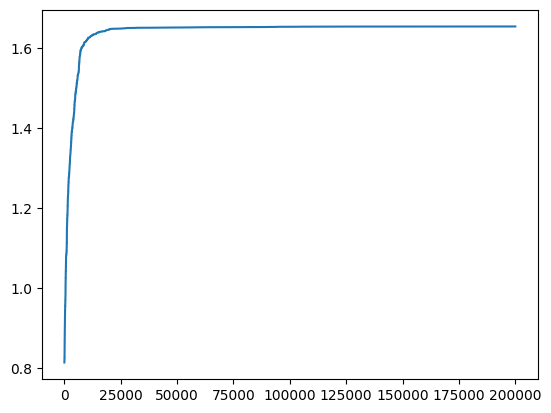

In [ ]:
@ti.func
def is_forbidden(x, y):  # 指定哪里是墙
    return y < -offset or y > 1 or (x < 0.0 and y < 0.0) or (x > 1.0 and y > -offset + 1.0)

best_score, xs, ys, rotations, sofa, maximal_area_record = run_optimization(
    is_forbidden,
    xs,
    ys,
    rotations,
    # initial_xs=zoom(xs, zoom=2, order=1),
    # initial_ys=zoom(ys, zoom=2, order=1),
    # initial_rotations=zoom(rotations, zoom=2, order=1),
    mutation_sigma_pos = 0.02,  # 变异率
    mutation_sigma_rotation = 0.004,  # 变异率
    iterations = 200000,  # 200000
    trajectory_upsampling=41,  # 41 101
    resolution=1024,  # 1024 2000
    print_every=500,  # 1000
    save_image_every=83,
    save_image_path='../images/双拐角_offset1.4/sofa_',
    save_image_start_id=0,
    save_trajectory_path='../trajectory/双拐角_offset1.4/sofa_'
)
print(f"Estimated maximal sofa area (by sampling): {best_score:.5f}")
# save mask image as PNG if pillow is available

img = (sofa * 255).astype(np.uint8)
im = Image.fromarray(img.T[::-1])
im.save('../sofa_survivors.png')
print('../Saved sofa_survivors.png')
plt.plot(maximal_area_record)

In [ ]:
# 批量计算

for offset in np.arange(1.4, 2.99, 0.1):
    print(f'offset = {offset}')
    xs, ys, rotations = init_trajectory(  # 初始轨迹
        sofa_w=sofa_w,
        sofa_h=sofa_h,
        control_point_num=30,  # 轨迹的控制点数量
        middle_rotation=-0.25 * np.pi,  # -0.1 * np.pi
        offset=offset
    )

    @ti.func
    def is_forbidden(x, y):  # 指定哪里是墙
        return y < -offset or y > 1 or (x < 0.0 and y < 0.0) or (x > 1.0 and y > -offset + 1.0)

    best_score, xs, ys, rotations, sofa, maximal_area_record = run_optimization(
        is_forbidden,
        xs,
        ys,
        rotations,
        # initial_xs=zoom(xs, zoom=2, order=1),
        # initial_ys=zoom(ys, zoom=2, order=1),
        # initial_rotations=zoom(rotations, zoom=2, order=1),
        mutation_sigma_pos = 0.02,  # 变异率
        mutation_sigma_rotation = 0.004,  # 变异率
        iterations = 40000,  # 200000
        trajectory_upsampling=41,  # 41 101
        resolution=1024,  # 1024 2000
        print_every=500,  # 1000
        save_image_every=83,
        save_image_path=f'../images/双拐角_offset{offset:.1f}/sofa_',
        save_image_start_id=0,
        save_trajectory_path=f'../trajectory/双拐角_offset{offset:.1f}/sofa_'
    )

offset = 1.4
Initial survivors: 0.8240113854408264
iter 500 / 40000, maximal_area=0.9957292675971985
iter 1000 / 40000, maximal_area=1.119291067123413
iter 1500 / 40000, maximal_area=1.1711342334747314
iter 2000 / 40000, maximal_area=1.2005966901779175
iter 2500 / 40000, maximal_area=1.2340974807739258
iter 3000 / 40000, maximal_area=1.2516788244247437
iter 3500 / 40000, maximal_area=1.2827215194702148
iter 4000 / 40000, maximal_area=1.3083797693252563
iter 4500 / 40000, maximal_area=1.331708550453186
iter 5000 / 40000, maximal_area=1.3618030548095703
iter 5500 / 40000, maximal_area=1.3811753988265991
iter 6000 / 40000, maximal_area=1.4026899337768555
iter 6500 / 40000, maximal_area=1.437595248222351
iter 7000 / 40000, maximal_area=1.465465784072876
iter 7500 / 40000, maximal_area=1.4853532314300537
iter 8000 / 40000, maximal_area=1.5063291788101196
iter 8500 / 40000, maximal_area=1.5147688388824463
iter 9000 / 40000, maximal_area=1.529868721961975
iter 9500 / 40000, maximal_area=1.540

In [14]:
f'{np.arange(1.1, 3, 0.1)[2]:.1f}'

'1.3'

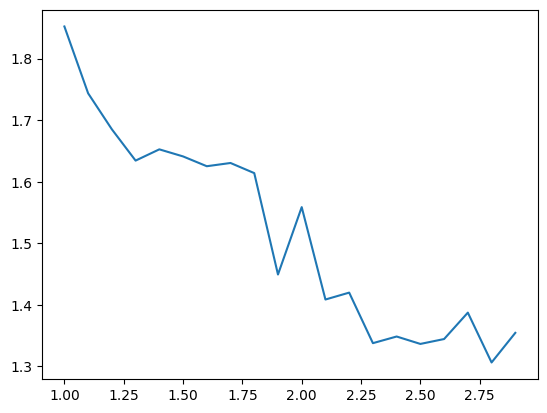

In [ ]:
from utils import get_sofa

data_to_plot = []
for offset in np.arange(1, 3, 0.1):
    if np.min(np.abs(offset - np.array([1, 3]))) < 0.0001:
        file = f'../trajectory/双拐角_offset{int(offset)}/sofa_480.npy'
    else:
        file = f'../trajectory/双拐角_offset{offset:.1f}/sofa_480.npy'
    xs, ys, rotations = np.load(file)
    
    @ti.func
    def is_forbidden(x, y):  # 指定哪里是墙。双拐角
        return y < -offset or y > 1 or (x < 0.0 and y < 0.0) or (x > 1.0 and y > -offset + 1.0)

    sofa = get_sofa(is_forbidden, xs, ys, rotations, resolution=1000, trajectory_upsampling=41)

    data_to_plot.append([offset, int(np.sum(sofa)) / sofa.shape[1] ** 2])
data_to_plot = np.array(data_to_plot)
plt.plot(data_to_plot[:, 0], data_to_plot[:, 1], 'o', markersize=2)

In [9]:
data_to_plot[:, 1]

array([1.85229917, 1.74372422, 1.68523238, 1.63436134, 1.65264389,
       1.64115728, 1.62522622, 1.63048323, 1.6140474 , 1.44928286,
       1.55875654, 1.40864266, 1.41984611, 1.33772853, 1.3485257 ,
       1.33647276, 1.34442598, 1.38733149, 1.30633426, 1.35447215])

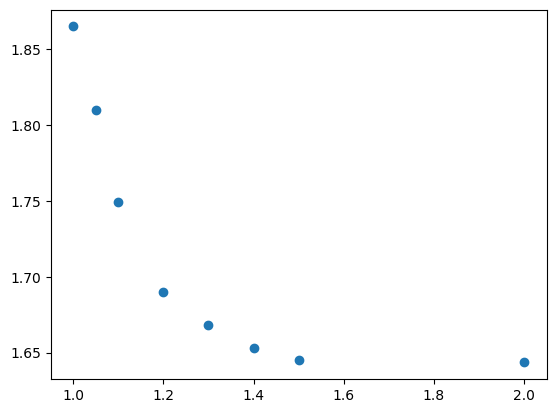

In [38]:
data_to_plot = [
    [1, 1.865],
    [1.05, 1.809625169840603],
    [1.1, 1.7492984011213313],
    [1.2, 1.6900481841240826],
    [1.3, 1.668412868320242],
    [1.4, 1.6531111117926887],
    [1.5, 1.645320680527909],
    [2.0, 1.643452817283716]
]
data_to_plot = np.array(data_to_plot)
plt.plot(data_to_plot[:, 0], data_to_plot[:, 1], 'o')

转折点在何处？或者并没有清晰的转折点？